In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%env CHRONOSTRAIN_INI=chronostrain.ini
%env CHRONOSTRAIN_LOG_INI=logging.ini
%env JAX_PLATFORM_NAME=cpu


import itertools
from tqdm.notebook import tqdm
from pathlib import Path
from typing import *

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as mtransforms
import string
import seaborn as sb

from helpers import *

env: CHRONOSTRAIN_INI=chronostrain.ini
env: CHRONOSTRAIN_LOG_INI=logging.ini
env: JAX_PLATFORM_NAME=cpu


In [3]:
# Change these to whatever is reflected in the settings. (see README.md for the semisynthetic subfolder).
DATA_DIR = Path("/mnt/e/semisynthetic_data")

PHYLOGROUP_PATH = Path("/mnt/e/semisynthetic_data/databases/phylogroups.txt")
STRAINGE_CLUSTER_PATH = Path("/mnt/e/semisynthetic_data/databases/strainge/clusters.tsv")
MGEMS_CLUSTER_PATH = Path("/mnt/e/semisynthetic_data/databases/mgems/Ecoli/ref_info.tsv")
STRAINEST_CLUSTER_PATH = Path("/mnt/e/semisynthetic_data/databases/StrainEst/snv_profiling_db/cluster_members.txt")
CHRONOSTRAIN_CLUSTER_PATH = Path("/mnt/e/semisynthetic_data/databases/chronostrain/ecoli.clusters.txt")

assert DATA_DIR.exists()
assert PHYLOGROUP_PATH.exists()
assert STRAINGE_CLUSTER_PATH.exists()
assert MGEMS_CLUSTER_PATH.exists()
assert STRAINEST_CLUSTER_PATH.exists()
assert CHRONOSTRAIN_CLUSTER_PATH.exists()

min ratio per timepoint:  [0.0130719  0.03370787 0.00690846 0.00434783 0.01284797 0.00258398]


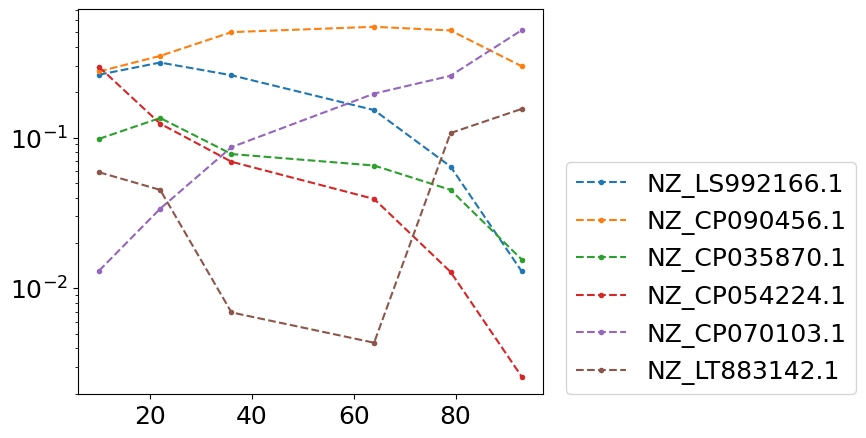

In [4]:
# ============= test
def visualize_example_ground_truth(replicate: int):
    target_accs, time_points, ground_truth = load_ground_truth(mut_ratio="1.0", replicate=replicate, data_dir=DATA_DIR)
    print("min ratio per timepoint: ", ground_truth.min(axis=1))
    colors = sb.color_palette("tab10")
    palette = {acc: colors[i] for i, acc in enumerate(target_accs)}
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    plot_ground_truth(ax, target_accs, time_points, ground_truth, palette, label=True)
    ax.legend(loc=[1.05, 0.0])
    ax.set_yscale('log')

plt.rcParams.update({'font.size': 18})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

visualize_example_ground_truth(replicate=1)
plots_dir = Path() / 'plots'
plots_dir.mkdir(exist_ok=True)
plt.savefig(plots_dir / 'semisynthetic_truth.pdf', format='pdf')

In [5]:
import numpy as np
_, time_points, ground_truth = load_ground_truth(mut_ratio="1.0", replicate=1, data_dir=DATA_DIR)

NUM_BINS = 4
ratio_bins = np.histogram_bin_edges(np.log10(ground_truth), bins=NUM_BINS)
print(ratio_bins)

[-2.58771097 -2.00698768 -1.42626439 -0.84554111 -0.26481782]


In [6]:
def compile_hierarchical_mgems(subdir_name: str = 'mgems', lod=0.001):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='hierarhical mGEMS eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                msweep_hierarchical_results(
                    DATA_DIR,
                    mut_ratio, replicate, read_depth, trial,
                    msweep_clust_path=MGEMS_CLUSTER_PATH, phylogroup_path=PHYLOGROUP_PATH,
                    abundance_bins=ratio_bins,
                    subdir_name=subdir_name, lod=lod
                )
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError as e:
            print(e)
            pass
        except Exception:
            print("[mGEMS hierarchical] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_straingst(subdir_name: str = 'straingst'):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='StrainGST eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                straingst_results(
                    DATA_DIR,
                    mut_ratio, replicate, read_depth, trial,
                    cluster_path=STRAINGE_CLUSTER_PATH,
                    phylogroup_path=PHYLOGROUP_PATH,
                    abundance_bins=ratio_bins, subdir_name=subdir_name
                )
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainGST] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_strainest():
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='StrainEst eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                strainest_results(
                    DATA_DIR,
                    mut_ratio, replicate, read_depth, trial,
                    abundance_bins=ratio_bins,
                    cluster_path=STRAINEST_CLUSTER_PATH, phylogroup_path=PHYLOGROUP_PATH,
                )
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except StrainEstInferenceError as e:
            print("[StrainEst] Result has zero abundance. (mut_ratio = {} | replicate = {} | read_depth = {} | trial = {})".format(
                mut_ratio, replicate, read_depth, trial
            ))
            pass
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainEst] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_chronostrain(subdir_name: str = 'chronostrain', posterior_threshold: float = 0.9901, prior_p=0.001):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='ChronoStrain eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            df_entries.append(
                chronostrain_results(
                    DATA_DIR,
                    mut_ratio, replicate, read_depth, trial,
                    abundance_bins=ratio_bins, subdir_name=subdir_name, posterior_threshold=posterior_threshold, prior_p=prior_p,
                    chronostrain_cluster_path=CHRONOSTRAIN_CLUSTER_PATH,
                    phylogroup_path=PHYLOGROUP_PATH,
                )
            )
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError as e:
            print(e)
            pass
        except Exception:
            print("[chronostrain] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)


def compile_chronostrain_indiv(subdir_name: str = 'chronostrain_indiv', posterior_threshold: float = 0.9901):
    df_entries = []
    pbar = tqdm(
        itertools.product(mut_ratios, replicates, read_depths, trials), 
        total=len(mut_ratios) * len(replicates) * len(read_depths) * len(trials),
        desc='ChronoStrain-Indiv eval'
    )
    for mut_ratio, replicate, read_depth, trial in pbar:
        try:
            res = chronostrain_indiv_results(
                DATA_DIR,
                mut_ratio, replicate, read_depth, trial,
                abundance_bins=ratio_bins, subdir_name=subdir_name, posterior_threshold=posterior_threshold,
				chronostrain_cluster_path=CHRONOSTRAIN_CLUSTER_PATH,
				phylogroup_path=PHYLOGROUP_PATH,
            )
            df_entries.append(res)
            pbar.set_postfix({'n_entries': len(df_entries)})
        except FileNotFoundError as e:
            print(e)
            pass
        except Exception:
            print("[chronostrain-indiv] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return pd.DataFrame(df_entries)

In [8]:
mut_ratios = ['1.0']
replicates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
read_depths = [2500, 5000, 10000, 20000, 40000]
trials = [1, 2]


NUM_BACKGROUND_READS = [
    11941733, 12665662, 12996644, 9589266, 9350531, 9685560
]
TOTAL_BACKGROUND_READS = np.sum(NUM_BACKGROUND_READS)


# These take a while to load.
chronostrain_err_df = compile_chronostrain(posterior_threshold=0.95)
chronostrain_indiv_err_df = compile_chronostrain_indiv(posterior_threshold=0.95)
mgems_hierarchical_err_df = compile_hierarchical_mgems(lod=0.001)
straingst_err_df = compile_straingst()
strainest_err_df = compile_strainest()

ChronoStrain eval:   0%|          | 0/100 [00:00<?, ?it/s]

ChronoStrain-Indiv eval:   0%|          | 0/100 [00:00<?, ?it/s]

/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/chronostrain.py:145: RuntimeWarning: invalid value encountered in divide
  SUBSET_pred = SUBSET_pred / SUBSET_pred.sum(axis=-1, keepdims=True)


mut_ratio = 1.0 | replicate = 6 | read_depth = 2500 | trial = 2 | Timepoint 0: [A] Found empty prediction through posterior filtering; defaulting to uniform profile.
mut_ratio = 1.0 | replicate = 6 | read_depth = 2500 | trial = 2 | Timepoint 0: [sim-only] Found empty prediction through posterior filtering; defaulting to uniform profile.


/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/chronostrain.py:145: RuntimeWarning: invalid value encountered in divide
  SUBSET_pred = SUBSET_pred / SUBSET_pred.sum(axis=-1, keepdims=True)


mut_ratio = 1.0 | replicate = 6 | read_depth = 10000 | trial = 2 | Timepoint 2: [A] Found empty prediction through posterior filtering; defaulting to uniform profile.
mut_ratio = 1.0 | replicate = 6 | read_depth = 10000 | trial = 2 | Timepoint 2: [sim-only] Found empty prediction through posterior filtering; defaulting to uniform profile.


/home/youn/work/chronostrain/examples/semisynthetic/notebooks/helpers/chronostrain.py:145: RuntimeWarning: invalid value encountered in divide
  SUBSET_pred = SUBSET_pred / SUBSET_pred.sum(axis=-1, keepdims=True)


mut_ratio = 1.0 | replicate = 7 | read_depth = 2500 | trial = 1 | Timepoint 5: [A] Found empty prediction through posterior filtering; defaulting to uniform profile.
mut_ratio = 1.0 | replicate = 7 | read_depth = 2500 | trial = 1 | Timepoint 5: [sim-only] Found empty prediction through posterior filtering; defaulting to uniform profile.


hierarhical mGEMS eval:   0%|          | 0/100 [00:00<?, ?it/s]

Output dir for mut_ratio=1.0, replicate=1, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=1, read_depth=5000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=1, read_depth=10000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=1, read_depth=20000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=1, read_depth=40000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=2, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=2, read_depth=5000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=2, read_depth=10000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=2, read_depth=20000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=2, read_depth=40000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=3, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=3, read_depth=5000, trial=2 not found.
Output dir for mut_ratio=1.0, replicate=3, rea

StrainGST eval:   0%|          | 0/100 [00:00<?, ?it/s]

StrainEst eval:   0%|          | 0/100 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.

In [9]:
err_df = pd.concat([
    chronostrain_err_df.assign(
        AUROC=chronostrain_err_df['AUROC_abundance'], 
        # AUROC=chronostrain_err_df['AUROC_posterior']  # Using this strictly makes chronostrain's AUROC Better, but it's an unfair metric.
    ), 
    chronostrain_indiv_err_df.assign(
        AUROC=chronostrain_indiv_err_df['AUROC_posterior']  # for the "indiv" runs, the posterior is (TxS), no collapsing is performed.
    ), 
    mgems_hierarchical_err_df.assign(Method='mGEMS').assign(
        AUROC=mgems_hierarchical_err_df['AUROC']  # don't use AUROC_Collapsed, keep the full TxS classification
    ),
    straingst_err_df.assign(
        AUROC=straingst_err_df['AUROC']
    ),
    strainest_err_df.assign(
        AUROC=strainest_err_df['AUROC']
    )
], ignore_index=True)
display(err_df)

,MutRatio,Replicate,ReadDepth,Trial,Method,NumClusters,TVErrorSim,TVErrorA,RMSErrorSim,RMSErrorA,...,RMSErrorSim_Bin2,RMSErrorSim_Bin3,RMSErrorSim_Strain0,RMSErrorSim_Strain1,RMSErrorSim_Strain2,RMSErrorSim_Strain3,RMSErrorSim_Strain4,RMSErrorSim_Strain5,AUROC,AUROC_Collapsed
0,1.0,1,2500,1,ChronoStrain,341,0.170218,0.194645,1.134021,0.214854,...,1.383723,0.936037,2.671332,0.183441,0.331869,0.075627,0.350281,0.554802,0.915409,NaN
1,1.0,1,2500,2,ChronoStrain,341,0.153569,0.154757,1.173553,0.172173,...,1.806890,0.251666,0.213398,2.794513,0.336978,0.089573,0.473037,0.251353,0.916307,NaN
2,1.0,1,5000,1,ChronoStrain,341,0.100450,0.102753,0.287432,0.074081,...,0.291319,0.077250,0.222631,0.267014,0.164710,0.043033,0.386544,0.443221,0.999945,NaN
3,1.0,1,5000,2,ChronoStrain,341,0.094918,0.096043,0.252380,0.074676,...,0.208979,0.108259,0.383678,0.255049,0.271771,0.077768,0.181490,0.238893,0.999876,NaN
4,1.0,1,10000,1,ChronoStrain,341,0.076723,0.079706,0.321569,0.106352,...,0.144791,0.075717,0.517847,0.318900,0.212450,0.053488,0.222636,0.391171,0.999655,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,1.0,10,10000,2,StrainEst,342,0.310076,0.628012,2.068524,0.571687,...,2.737026,1.303838,1.887670,2.794513,1.807140,2.586247,1.485961,1.450037,0.678296,0.797123
398,1.0,10,20000,1,StrainEst,342,0.214288,0.497686,1.642019,0.584237,...,2.213018,0.201133,1.487347,2.794513,1.353165,1.868968,0.118197,0.886157,0.760554,0.883929
399,1.0,10,20000,2,StrainEst,342,0.226800,0.454197,1.577543,0.564075,...,2.064690,0.308871,1.883369,2.250834,1.353795,1.904243,0.179604,0.891628,0.775070,0.966270
400,1.0,10,40000,1,StrainEst,342,0.193103,0.351599,1.333231,0.561079,...,1.535993,0.189949,1.556594,1.836188,1.350847,1.485075,0.214185,0.874115,0.817695,0.997024


In [26]:
err_df.columns

Index(['MutRatio', 'Replicate', 'ReadDepth', 'Trial', 'Method', 'NumClusters',
       'TVErrorSim', 'TVErrorA', 'RMSErrorSim', 'RMSErrorA', 'AUROC_abundance',
       'AUROC_posterior', 'RankCorrelationSim', 'RankCorrelationA', 'Runtime',
       'RMSErrorSim_Bin0', 'RMSErrorSim_Bin1', 'RMSErrorSim_Bin2',
       'RMSErrorSim_Bin3', 'RMSErrorSim_Strain0', 'RMSErrorSim_Strain1',
       'RMSErrorSim_Strain2', 'RMSErrorSim_Strain3', 'RMSErrorSim_Strain4',
       'RMSErrorSim_Strain5', 'AUROC', 'AUROC_Collapsed', 'ReadDepthPct',
       'RuntimeMinutes'],
      dtype='object')

In [30]:
err_df[[
    'MutRatio', 'Replicate', 'ReadDepth', 'Trial', 'Method', 'NumClusters', 'RMSErrorSim', 'RMSErrorA', 'AUROC', 'RuntimeMinutes'
]].to_csv("plots/semisynthetic_results_main.tsv", sep='\t', index=False)

# P-values

In [11]:
# Report p-values
import numpy as np
import scipy
import scipy.stats
import statsmodels
import statsmodels.stats.multitest
import itertools


def compute_pvalue_df(metrics_df: pd.DataFrame, base_methods: List[str], comparator_methods: List[str], y_cols: List[str], category: str = 'ReadDepth', alts: List[str] = None):
    pvalue_entries = []
    if alts is None:
        alts = ['two-sided'] * len(y_cols)
    for cat_value, cat_section in metrics_df.groupby(category):
        rd_section = cat_section.sort_values('Trial')
        for method, method2 in itertools.product(base_methods, comparator_methods):
            if method == method2:
                continue
            entry = {
                category: cat_value,
                'Method': method,
                'Comparator': method2
            }
    
            m1 = rd_section.loc[rd_section['Method'] == method, :].sort_values(['Replicate', 'Trial'])
            m2 = rd_section.loc[rd_section['Method'] == method2, :].sort_values(['Replicate', 'Trial'])
            if m2.shape[0] == 0:
                print("Section not available for method `{}` @ {}={}.".format(method2, category, cat_value))
                continue
            
            for y, alt in zip(y_cols, alts):
                a = m1[y].to_numpy()
                b = m2[y].to_numpy()
                
                valid_indices, = np.where(~np.isnan(b))
                a = a[valid_indices]
                b = b[valid_indices]
    
                if len(a) > len(b):
                    b = np.concatenate([b, b[-1] * np.ones(len(a) - len(b))])
    
                statistic, pvalue = scipy.stats.wilcoxon(a, b, alternative=alt)
                    
                entry[f'Pval_{y}'] = pvalue
                entry[f'Stat_{y}'] = statistic
            pvalue_entries.append(entry)
    pvalues = pd.DataFrame(pvalue_entries)
    
    for col in pvalues.columns:
        if col.startswith('Pval'):
            nan_locs = pvalues[col].isna()

            # only evaluate using non-nan values.
            rej, pval_bh = statsmodels.stats.multitest.fdrcorrection(pvalues.loc[~nan_locs, col].to_numpy(), alpha=0.05, method='p') ## alpha doesn't matter here, we want to output raw p-values with multiple-hypothesis correction
            pvalues.loc[~nan_locs, f'{col}_Raw'] = pvalues[col]
            pvalues.loc[~nan_locs, col] = pval_bh
    return pvalues

In [29]:
pvalues = compute_pvalue_df(
    err_df, 
    base_methods=['ChronoStrain', 'ChronoStrain_Indiv'],
    comparator_methods=['ChronoStrain_Indiv', 'mGEMS', 'StrainGST', 'StrainEst'], 
    y_cols=['TVErrorSim', 'TVErrorA', 'RMSErrorSim', 'RMSErrorA', 'RankCorrelationSim', 'RankCorrelationA', 'AUROC']
)
display(pvalues)
pvalues.to_csv(plots_dir / "semisynthetic_pvalues_main.tsv", sep="\t", index=False)

Section not available for method `StrainEst` @ ReadDepth=2500.
Section not available for method `StrainEst` @ ReadDepth=2500.
Section not available for method `StrainEst` @ ReadDepth=5000.
Section not available for method `StrainEst` @ ReadDepth=5000.


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


,ReadDepth,Method,Comparator,Pval_TVErrorSim,Stat_TVErrorSim,Pval_TVErrorA,Stat_TVErrorA,Pval_RMSErrorSim,Stat_RMSErrorSim,Pval_RMSErrorA,...,Stat_RankCorrelationA,Pval_AUROC,Stat_AUROC,Pval_TVErrorSim_Raw,Pval_TVErrorA_Raw,Pval_RMSErrorSim_Raw,Pval_RMSErrorA_Raw,Pval_RankCorrelationSim_Raw,Pval_RankCorrelationA_Raw,Pval_AUROC_Raw
0,2500,ChronoStrain,ChronoStrain_Indiv,0.000004,0.0,0.000004,0.0,0.000005,0.0,0.000008,...,0.0,0.000045,5.0,0.000002,0.000002,0.000002,0.000002,0.609459,0.000008,0.000019
1,2500,ChronoStrain,mGEMS,0.012614,3.0,0.002752,0.0,0.004325,1.0,0.002752,...,0.0,0.005046,1.0,0.009766,0.001953,0.003906,0.001953,0.001953,0.001953,0.003906
2,2500,ChronoStrain,StrainGST,0.002467,24.0,0.000004,0.0,0.000030,4.0,0.000008,...,1.0,0.000007,0.0,0.001432,0.000002,0.000013,0.000002,0.009436,0.000004,0.000002
3,2500,ChronoStrain_Indiv,mGEMS,0.002752,0.0,0.921875,26.0,0.002523,0.0,0.002752,...,0.0,0.089776,10.0,0.001953,0.921875,0.001953,0.001953,0.001953,0.001953,0.083984
4,2500,ChronoStrain_Indiv,StrainGST,0.020486,42.0,0.002115,24.0,0.000005,0.0,0.985435,...,NaN,0.000434,14.0,0.017181,0.001432,0.000002,0.985435,NaN,NaN,0.000210
5,5000,ChronoStrain,ChronoStrain_Indiv,0.000004,0.0,0.000004,0.0,0.000005,0.0,0.000013,...,3.0,0.000644,17.0,0.000002,0.000002,0.000002,0.000004,0.048441,0.000010,0.000395
6,5000,ChronoStrain,mGEMS,0.370009,17.0,0.005265,1.0,0.002523,0.0,0.002752,...,0.0,0.005046,1.0,0.322266,0.003906,0.001953,0.001953,0.001953,0.001953,0.003906
7,5000,ChronoStrain,StrainGST,0.000012,2.0,0.000004,0.0,0.000218,12.0,0.000008,...,22.0,0.000007,0.0,0.000006,0.000002,0.000134,0.000002,0.164957,0.001017,0.000002
8,5000,ChronoStrain_Indiv,mGEMS,0.002752,0.0,0.795182,24.0,0.002523,0.0,0.002752,...,0.0,0.030273,6.0,0.001953,0.769531,0.001953,0.001953,0.001953,0.001953,0.027344
9,5000,ChronoStrain_Indiv,StrainGST,0.446029,83.0,0.000004,0.0,0.000005,0.0,0.429988,...,38.0,0.001045,20.0,0.430433,0.000002,0.000002,0.388376,0.784126,0.010689,0.000708


# Plots

In [36]:
def add_figure_labels(fig, axes, labels=None):
    """ add A/B/C/D labels """
    if labels is None:
        labels = [string.ascii_lowercase[n] for n in range(len(axes))]
    if len(labels) != len(axes):
        raise ValueError("Number of labels do not match number of axes.")
    for n, _ax in enumerate(axes):
        # _ax.text(-.1, 1.1, string.ascii_uppercase[n], transform=_ax.transAxes, size=20, weight='bold')
        trans = mtransforms.ScaledTranslation(-25/72, -3/72, fig.dpi_scale_trans)
        lbl = labels[n]
        _ax.text(
            0., 1.05, lbl, transform=_ax.transAxes + trans,
            va='bottom', fontfamily='sans-serif', weight='bold', size=15
        )

def annotate_pvalues(
    ax, 
    pvalue_df: pd.DataFrame, 
    err_df: pd.DataFrame, 
    column_name: str,
    sig_level: float, 
    method_order: List[str], 
    marker_str: str = "n.s.", 
    y_offset_factor: float = 0.2, 
    dy: float = None,
    overlap_gap: float = 0.1,
    show_nonsig: bool = True,
    cascade_above: bool = True,
    group_column: str = 'ReadDepth',
    font_size: float = 10.0,
):
    """
    Annotate non-significant pairs with a marker.
    :param offset_factor: controls the space between the bracket and the maximal datapoint (if cascade_above is True, otherwise computes the min)
    :param dy: the height of the bracket.
    :param overlap_gap: controls the height difference between overlapping brackets.
    :param show_nonsig: (default = True) if True, shows NONSIGNIFICANT pairs at the specified level.
    :param cascade_above: (default = True) if True, significance brackets cascade UPWARDS (so y-value is incremented) to avoid overlaps. if False, cascades DOWNWARDS instead.
    """
    method_indices = {m: i for i, m in enumerate(method_order)}
    group_indices = {r: i for i, r in enumerate(sorted(pd.unique(err_df[group_column])))}
    if show_nonsig:
        subsection = pvalue_df.loc[pvalue_df[f'Pval_{column_name}'] >= sig_level, [group_column, 'Method', 'Comparator', f'Pval_{column_name}']]
    else:
        subsection = pvalue_df.loc[pvalue_df[f'Pval_{column_name}'] < sig_level, :]
    if dy is None:
        dy = err_df[column_name].max() * 0.03
    overlap_offsets = {r: 0 for r in group_indices.keys()}

    # these are the seaborn x-coordinates per category (not counting offset)
    _spread = np.arange(0, len(method_order), dtype=float)
    _spread = 0.8 * (_spread / len(_spread))
    _spread = _spread - np.mean(_spread)
    def _get_method_xpos(method_name: str, group_name: int) -> float:
        ri = group_indices[group_name]
        mi = method_indices[method_name]
        return ri + _spread[mi]

    for group_name in group_indices.keys():
        overlap_offset = 0
        if cascade_above:
            y_base = err_df.loc[(err_df[group_column] == group_name), column_name].max()
        else:
            y_base = err_df.loc[(err_df[group_column] == group_name), column_name].min()
        group_section = subsection.loc[subsection[group_column] == group_name]
        for base_method, base_method_section in group_section.groupby("Method"):
            for _, row in base_method_section.iterrows():
                comparator = row['Comparator']
                x1 = _get_method_xpos(base_method, group_name)
                x2 = _get_method_xpos(comparator, group_name)
                if cascade_above:
                    y1 = y_base * (1 + y_offset_factor) + (overlap_offset * overlap_gap)
                    y2 = y1 + dy
                else:
                    y1 = y_base * (1 - y_offset_factor) - (overlap_offset * overlap_gap)
                    y2 = y1 - dy
                ax.plot([x1, x1, x2, x2], [y1, y2, y2, y1], color='black', linewidth=1.0, linestyle='-')
                ax.text(x=0.5 * (x1+x2), y=y2, s=marker_str, ha='center', va='bottom', size=font_size)
                overlap_offset += 1

## Paper-specific subplots

/tmp/ipykernel_578033/2212659517.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


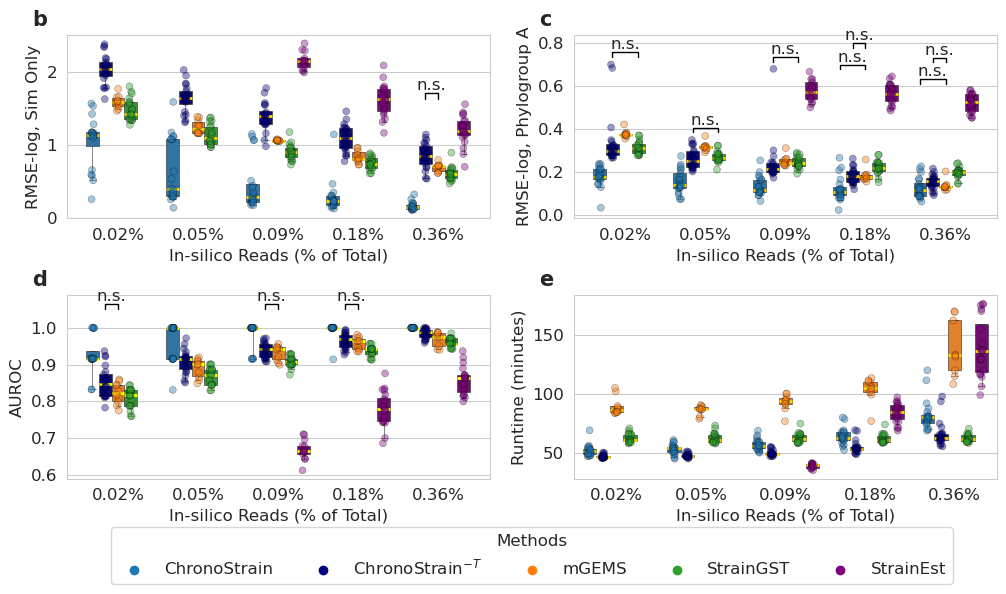

In [41]:
# fig, axes = plt.subplots(3, 4, figsize=(20, 10), height_ratios=[1, 10, 10])
fig = plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[10, 10, 1], hspace=0.6, wspace=0.2)

sb.set_style("whitegrid")

method_order = ['ChronoStrain', 'ChronoStrain_Indiv', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'ChronoStrain_Indiv': 'navy',
    'mGEMS': colors[1],
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}
method_labels = {
    'ChronoStrain': 'ChronoStrain',
    'ChronoStrain_Indiv': r'ChronoStrain$^{-T}$',
    'mGEMS': 'mGEMS',
    'StrainGST': 'StrainGST',
    'StrainEst': 'StrainEst',
}


legend_ax = fig.add_subplot(gs[-1, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), method_labels[m]) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=len(method_order))
legend_ax.axis('off')


err_df['ReadDepthPct'] = (
    100 
    * (err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))

axes = []
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel("RMSE-log, Sim Only")
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorSim', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorSim', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, pvalues, err_df, 'RMSErrorSim', 0.05, method_order, y_offset_factor=0.05, font_size=12.0)
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)

# =========== "baseline" error --> compare ground truth to random guess (uniform dist.)
# _, _, example_ground_truth = load_ground_truth(mut_ratio="1.0", replicate=1)
# baseline = np.ones(example_ground_truth.shape, dtype=float)
# baseline = baseline / np.sum(baseline, axis=-1, keepdims=True)
# print(example_ground_truth)
# print(baseline)
# baseline_rmse = rms(np.log10(baseline), np.log10(example_ground_truth))
# print(baseline_rmse)
# ax.axhline(baseline_rmse, color='black', alpha=0.3, linestyle='--')

ax = fig.add_subplot(gs[0, 1])
ax.set_ylabel("RMSE-log, Phylogroup A")
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorA', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='RMSErrorA', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, pvalues, err_df, 'RMSErrorA', 0.05, method_order, y_offset_factor=0.05, font_size=12.0)
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[1, 0])
ax.set_ylabel("AUROC")
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "yellow", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, pvalues, err_df, 'AUROC', 0.05, method_order, y_offset_factor=0.05, dy=0.015, font_size=12.0)
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)

# grouped_result = err_df.loc[err_df['Method'] == 'ChronoStrain'].groupby('ReadDepth')['RankCorrelation'].median()
# ax.plot(np.arange(6), grouped_result.to_numpy())
ax = fig.add_subplot(gs[1, 1])
ax.set_ylabel("Runtime (minutes)")
err_df['RuntimeMinutes'] = err_df['Runtime'] * 0.001 * (1/60) # milliseconds to minutes
sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y='RuntimeMinutes', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y='RuntimeMinutes', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)
# ax.set_yscale('log')





add_figure_labels(fig, axes, ['b', 'c', 'd', 'e'])

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_fixed_paper.pdf', format='pdf', bbox_inches='tight')

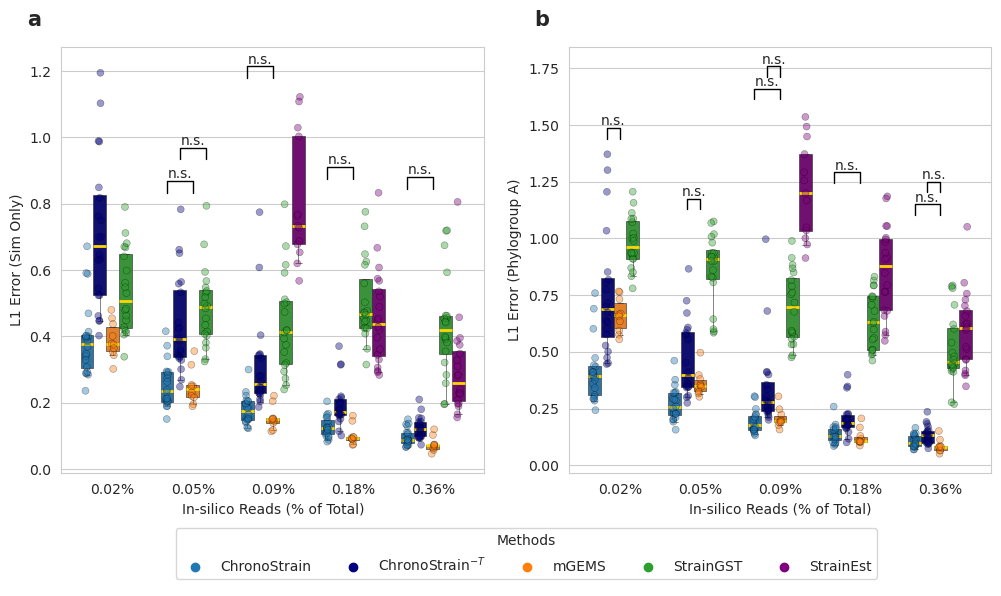

In [50]:
fig = plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, height_ratios=[10, 1], hspace=0.3, wspace=0.2)

sb.set_style("whitegrid")

method_order = ['ChronoStrain', 'ChronoStrain_Indiv', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'ChronoStrain_Indiv': 'navy',
    'mGEMS': colors[1],
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}
method_labels = {
    'ChronoStrain': 'ChronoStrain',
    'ChronoStrain_Indiv': r'ChronoStrain$^{-T}$',
    'mGEMS': 'mGEMS',
    'StrainGST': 'StrainGST',
    'StrainEst': 'StrainEst',
}


legend_ax = fig.add_subplot(gs[-1, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), method_labels[m]) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", loc="lower center", ncol=len(method_order))
legend_ax.axis('off')


# Convert from Total Variation to L1 metric (TV = 0.5 * L1)
_l1_df = err_df.assign(
    L1ErrorSim=err_df['TVErrorSim'] * 2, 
    L1ErrorA=err_df['TVErrorA'] * 2
)

pvalues = pvalues.assign(
    Pval_L1ErrorA=pvalues['Pval_TVErrorA'],
    Pval_L1ErrorSim=pvalues['Pval_TVErrorSim'],
    Pval_L1ErrorA_Raw=pvalues['Pval_TVErrorA_Raw'],
    Pval_L1ErrorSim_Raw=pvalues['Pval_TVErrorSim_Raw'],
    Stat_L1ErrorA=pvalues['Stat_TVErrorA'],
    Stat_L1ErrorSim=pvalues['Stat_TVErrorSim']
)

ax_array = []
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel("L1 Error (Sim Only)")
sb.stripplot(_l1_df, x='ReadDepthPct', order=x_order, y='L1ErrorSim', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(_l1_df, x='ReadDepthPct', order=x_order, y='L1ErrorSim', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('In-silico Reads (% of Total)')
annotate_pvalues(ax, l1_pvals, _l1_df, 'L1ErrorSim', 0.05, method_order, y_offset_factor=0.05)
ax.legend([],[], frameon=False)
ax_array.append(ax)


ax = fig.add_subplot(gs[0, 1])
ax.set_ylabel("L1 Error (Phylogroup A)")
sb.stripplot(_l1_df, x='ReadDepthPct', order=x_order, y='L1ErrorA', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(_l1_df, x='ReadDepthPct', order=x_order, y='L1ErrorA', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('In-silico Reads (% of Total)')
annotate_pvalues(ax, l1_pvals, _l1_df, 'L1ErrorA', 0.05, method_order, y_offset_factor=0.05)
ax.legend([],[], frameon=False)
ax_array.append(ax)

add_figure_labels(fig, ax_array, ['a', 'b'])

plt.savefig("plots/semisynthetic_L1.pdf", bbox_inches='tight', format='pdf')

In [51]:
pvalues[
    [
        'ReadDepth', 'Method', 'Comparator', 
        'Pval_L1ErrorSim', 'Pval_L1ErrorA', 'Pval_RMSErrorSim', 'Pval_RMSErrorA', 'Pval_AUROC', 
        'Pval_L1ErrorSim_Raw', 'Pval_L1ErrorA_Raw', 'Pval_RMSErrorSim_Raw', 'Pval_RMSErrorA_Raw', 'Pval_AUROC_Raw',
        'Stat_L1ErrorSim', 'Stat_L1ErrorA', 'Stat_RMSErrorSim', 'Stat_RMSErrorA', 'Stat_AUROC'
    ]
].to_csv(plots_dir / "pvalues_semisynthetic_fixed_paper.tsv", sep="\t", index=False)

# Strain-separated RMS-log

In [16]:
n_strains = ground_truth.shape[1]
strain_split_pvalues = compute_pvalue_df(
    err_df, 
    base_methods=['ChronoStrain', 'ChronoStrain_Indiv'],
    comparator_methods=['ChronoStrain_Indiv', 'mGEMS', 'StrainGST', 'StrainEst'], 
    y_cols=[f'RMSErrorSim_Strain{s_idx}' for s_idx in range(n_strains)]
)
display(strain_split_pvalues)
strain_split_pvalues.to_csv(plots_dir / "strain_split_pvalues.tsv", sep="\t", index=False)

Section not available for method `StrainEst` @ ReadDepth=2500.
Section not available for method `StrainEst` @ ReadDepth=2500.
Section not available for method `StrainEst` @ ReadDepth=5000.
Section not available for method `StrainEst` @ ReadDepth=5000.


/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


,ReadDepth,Method,Comparator,Pval_RMSErrorSim_Strain0,Stat_RMSErrorSim_Strain0,Pval_RMSErrorSim_Strain1,Stat_RMSErrorSim_Strain1,Pval_RMSErrorSim_Strain2,Stat_RMSErrorSim_Strain2,Pval_RMSErrorSim_Strain3,...,Pval_RMSErrorSim_Strain4,Stat_RMSErrorSim_Strain4,Pval_RMSErrorSim_Strain5,Stat_RMSErrorSim_Strain5,Pval_RMSErrorSim_Strain0_Raw,Pval_RMSErrorSim_Strain1_Raw,Pval_RMSErrorSim_Strain2_Raw,Pval_RMSErrorSim_Strain3_Raw,Pval_RMSErrorSim_Strain4_Raw,Pval_RMSErrorSim_Strain5_Raw
0,2500,ChronoStrain,ChronoStrain_Indiv,0.000941,5.0,0.001277,6.0,0.001362,1.0,0.000024,...,0.001136,0.0,0.001059,6.0,0.000455,0.000536,0.000352,0.000002,0.000293,0.000342
1,2500,ChronoStrain,mGEMS,0.058218,8.0,0.009082,2.0,0.089040,8.0,0.004325,...,0.769531,24.0,0.017808,3.0,0.048828,0.005859,0.048828,0.001953,0.769531,0.009766
2,2500,ChronoStrain,StrainGST,0.029699,45.0,0.000688,14.0,0.257738,71.0,0.000049,...,0.146764,63.0,0.000517,12.0,0.023951,0.000210,0.216167,0.000010,0.123093,0.000134
3,2500,ChronoStrain_Indiv,mGEMS,0.526131,20.0,0.904027,25.0,0.012974,2.0,0.341484,...,0.004397,0.0,0.873893,25.0,0.492188,0.845703,0.005859,0.275391,0.001953,0.845703
4,2500,ChronoStrain_Indiv,StrainGST,0.006848,32.0,0.056349,50.0,0.000962,12.0,0.310691,...,0.000493,6.0,0.251038,70.0,0.004860,0.039989,0.000134,0.230513,0.000027,0.202450
5,5000,ChronoStrain,ChronoStrain_Indiv,0.000520,1.0,0.000059,3.0,0.001081,1.0,0.000024,...,0.000690,0.0,0.001164,8.0,0.000155,0.000010,0.000233,0.000002,0.000132,0.000463
6,5000,ChronoStrain,mGEMS,0.006231,1.0,0.003784,0.0,0.176376,12.0,0.008073,...,0.177316,13.0,0.090820,9.0,0.003906,0.001953,0.130859,0.003906,0.160156,0.064453
7,5000,ChronoStrain,StrainGST,0.006231,31.0,0.000030,0.0,0.100333,54.0,0.000024,...,0.023451,40.0,0.024983,41.0,0.004221,0.000002,0.058258,0.000004,0.013617,0.015312
8,5000,ChronoStrain_Indiv,mGEMS,0.356794,17.0,0.952604,26.0,0.356794,17.0,0.921875,...,0.004397,0.0,0.921875,26.0,0.322266,0.921875,0.322266,0.921875,0.001953,0.921875
9,5000,ChronoStrain_Indiv,StrainGST,0.000579,15.0,0.571788,86.0,0.017171,36.0,0.604362,...,0.001815,19.0,0.020803,39.0,0.000261,0.498009,0.008308,0.545876,0.000586,0.012079


/tmp/ipykernel_578033/1160079763.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


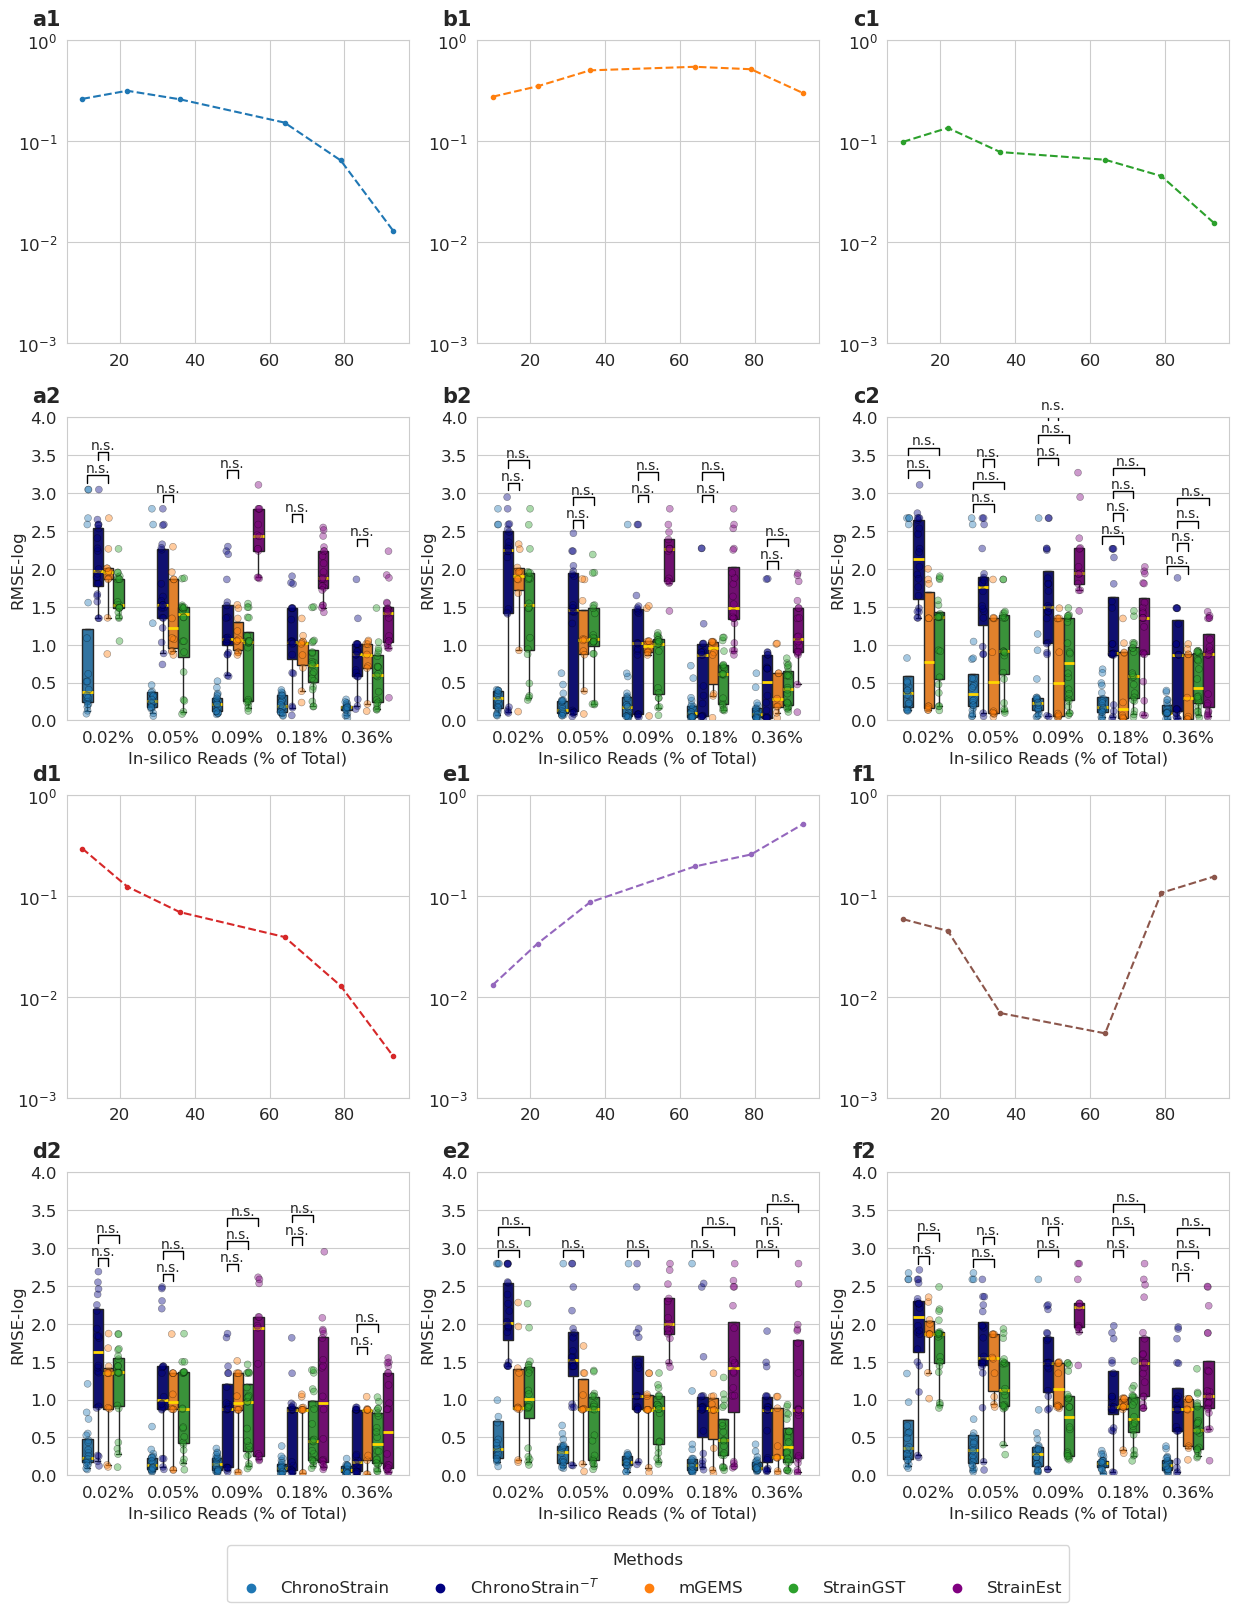

In [17]:
n_strains = ground_truth.shape[1]
assert n_strains == 6  # plot layout is 3x2, which hard-codes the assumption that there are six ground-truth strains.

width, height = (15, 20)
fig = plt.figure(figsize=(width, height))

plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=3, nrows=1+4, figure=fig, height_ratios=[10, 10, 10, 10, 1], hspace=0.3, wspace=0.2)
sb.set_style("whitegrid")


method_order = ['ChronoStrain', 'ChronoStrain_Indiv', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'ChronoStrain_Indiv': 'navy',
    'mGEMS': colors[1],
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}
method_labels = {
    'ChronoStrain': 'ChronoStrain',
    'ChronoStrain_Indiv': r'ChronoStrain$^{-T}$',
    'mGEMS': 'mGEMS',
    'StrainGST': 'StrainGST',
    'StrainEst': 'StrainEst',
}


axes = []
legend_ax = fig.add_subplot(gs[-1, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), method_labels[m]) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=5)
legend_ax.axis('off')


err_df['ReadDepthPct'] = (
    100 
    * (err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))


# === plot truth
colors = sb.color_palette("tab10")
for i in range(n_strains):
    c = colors[i]
    traj = ground_truth[:, i]
    if i < 3:
        ax = fig.add_subplot(gs[0, i])
    else:
        ax = fig.add_subplot(gs[2, i-3])
    ax.plot(time_points, traj, color=c, linestyle='--', marker='.', lw=1.5)
    ax.set_ylim(1e-3, 1.0)
    ax.set_yscale('log')
    axes.append(ax)

for s_idx in range(n_strains):
    if s_idx < 3:
        ax = fig.add_subplot(gs[1, s_idx])
    else:
        ax = fig.add_subplot(gs[3, s_idx-3])
    # ax.set_title(f"Strain idx {s_idx}")
    ax.set_ylabel('RMSE-log')
    ax.set_xlabel('In-silico Reads (% of Total)')
    sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Strain{s_idx}', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, alpha=0.4, hue_order=method_order, palette=method_palette, edgecolor='black')
    sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Strain{s_idx}', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
    annotate_pvalues(ax, strain_split_pvalues, err_df, f'RMSErrorSim_Strain{s_idx}', 0.05, method_order, y_offset_factor=0.03, dy=0.1, overlap_gap=0.30)
    ax.legend([],[], frameon=False)
    axes.append(ax)
    ax.set_ylim(0, 4.0)





add_figure_labels(fig, axes, ['a1', 'b1', 'c1', 'd1', 'e1', 'f1'] + ['a2', 'b2', 'c2', 'd2', 'e2', 'f2'])
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_RMSE_split_by_strain.pdf', format='pdf', bbox_inches='tight')

# Binned RMS-log

In [18]:
n_bins = len(ratio_bins) - 1
n_strains = ground_truth.shape[1]
binned_abundance_pvalues = compute_pvalue_df(
    err_df, 
    base_methods=['ChronoStrain', 'ChronoStrain_Indiv'],
    comparator_methods=['ChronoStrain_Indiv', 'mGEMS', 'StrainGST', 'StrainEst'], 
    y_cols=[f'RMSErrorSim_Bin{bin_idx}' for bin_idx in range(n_bins)]
)
display(binned_abundance_pvalues)
binned_abundance_pvalues[
    [
        'ReadDepth', 'Method', 'Comparator',
        'Pval_RMSErrorSim_Bin0', 'Pval_RMSErrorSim_Bin1', 'Pval_RMSErrorSim_Bin2', 'Pval_RMSErrorSim_Bin3',
        'Pval_RMSErrorSim_Bin0_Raw', 'Pval_RMSErrorSim_Bin1_Raw', 'Pval_RMSErrorSim_Bin2_Raw', 'Pval_RMSErrorSim_Bin3_Raw',
        'Stat_RMSErrorSim_Bin0', 'Stat_RMSErrorSim_Bin1', 'Stat_RMSErrorSim_Bin2', 'Stat_RMSErrorSim_Bin3',
    ]
].to_csv(plots_dir / "binned_abundance_pvalues.tsv", sep="\t", index=False)

/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
/home/youn/mambaforge/envs/chronostrain2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


Section not available for method `StrainEst` @ ReadDepth=2500.
Section not available for method `StrainEst` @ ReadDepth=2500.
Section not available for method `StrainEst` @ ReadDepth=5000.
Section not available for method `StrainEst` @ ReadDepth=5000.


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

In [ ]:
n_bins = len(ratio_bins) - 1
n_cols = 2
n_rows = int(np.ceil(n_bins / n_cols))

width, height = (n_rows * 5, 1 + n_cols * 4)
fig = plt.figure(figsize=(width, height))

plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gs = gridspec.GridSpec(ncols=n_cols, nrows=1 + n_rows, figure=fig, height_ratios=[10] * n_rows + [1], hspace=0.6, wspace=0.3)
sb.set_style("whitegrid")


method_order = ['ChronoStrain', 'ChronoStrain_Indiv', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'ChronoStrain_Indiv': 'navy',
    'mGEMS': colors[1],
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}
method_labels = {
    'ChronoStrain': 'ChronoStrain',
    'ChronoStrain_Indiv': r'ChronoStrain$^{-T}$',
    'mGEMS': 'mGEMS',
    'StrainGST': 'StrainGST',
    'StrainEst': 'StrainEst',
}


axes = []
legend_ax = fig.add_subplot(gs[-1, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), method_labels[m]) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, 0), loc="lower center", ncol=5)
legend_ax.axis('off')


err_df['ReadDepthPct'] = (
    100 
    * (err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))


remaining_grid = [
    gs[i, j]
    for i in range(n_rows)
    for j in range(n_cols)
]
for bin_idx, ax_grid in zip(range(n_bins), remaining_grid[::-1]):  # note: undo this flip later.
    ax = fig.add_subplot(ax_grid)
    bin_left = ratio_bins[bin_idx]
    bin_right = ratio_bins[bin_idx + 1]
    ax.set_title(r"${:.2f}".format(bin_left) + r"\leq \log_{10}(x)" + r"\leq {:.2f}$".format(bin_right))
    sb.stripplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Bin{bin_idx}', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, alpha=0.4, hue_order=method_order, palette=method_palette, edgecolor='black')
    sb.boxplot(err_df, x='ReadDepthPct', order=x_order, y=f'RMSErrorSim_Bin{bin_idx}', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
    annotate_pvalues(ax, binned_abundance_pvalues, err_df, f'RMSErrorSim_Bin{bin_idx}', 0.05, method_order, y_offset_factor=0.10, dy=0.07, overlap_gap=0.25)
    ax.set_xlabel('In-silico Reads (% of Total)')
    ax.set_ylabel('RMSE-log, Sim Only')
    ax.legend([],[], frameon=False)
    axes.append(ax)
    
axes = axes[::-1]  # we flipped the axes order.
for ax in axes:
    ax.sharey(axes[2])


add_figure_labels(fig, axes, list('abcdefghijkl')[:len(axes)])
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_RMSE_binned_by_abundance.pdf', format='pdf', bbox_inches='tight')

# AUROC, both ways

/tmp/ipykernel_996060/4087179600.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


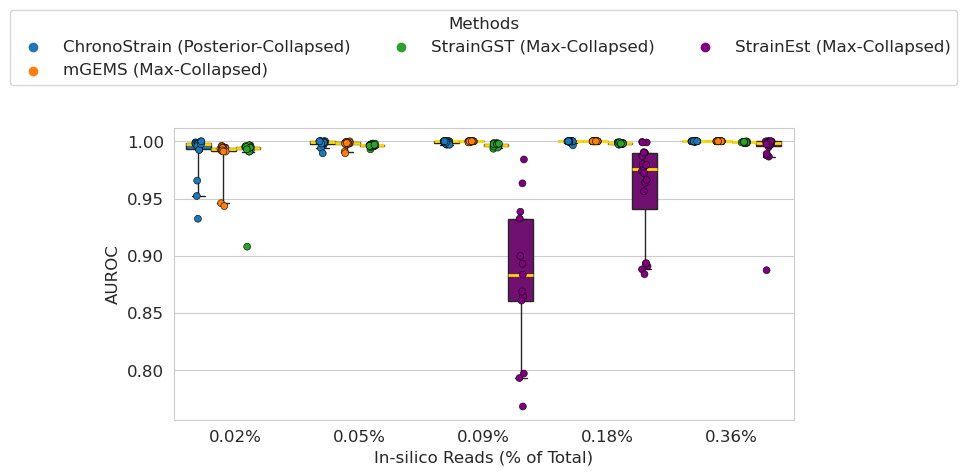

In [194]:
# fig, axes = plt.subplots(3, 4, figsize=(20, 10), height_ratios=[1, 10, 10])
width, height = (8, 5)
fig = plt.figure(figsize=(width, height))
plt.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[1, 10], hspace=0.4, wspace=0.2)

sb.set_style("whitegrid")

# err_df = pd.concat([msweep_err_df, chronostrain_err_df, straingst_err_df, strainest_err_df], ignore_index=True)
auroc_comparison_err_df = pd.concat([
    # mgems_err_df,
    chronostrain_err_df.assign(
        AUROC=chronostrain_err_df['AUROC_posterior'],
        Method='ChronoStrain'
    ),
    mgems_hierarchical_err_df.assign(
        AUROC=mgems_hierarchical_err_df['AUROC_Collapsed'],
        Method='mGEMS',
    ),
    straingst_err_df.assign(
        AUROC=straingst_err_df['AUROC_Collapsed'],
    ), 
    strainest_err_df.assign(
        AUROC=strainest_err_df['AUROC_Collapsed'],
    )
], ignore_index=True)


auroc_comparison_err_df['ReadDepthPct'] = (
    100 
    * (auroc_comparison_err_df['ReadDepth'] * len(NUM_BACKGROUND_READS))
    / (
        (len(NUM_BACKGROUND_READS) * auroc_comparison_err_df['ReadDepth']) + TOTAL_BACKGROUND_READS
    )
).apply(lambda x: '{:.2f}%'.format(x))
x_order = sorted(pd.unique(err_df['ReadDepthPct']))


# method_order = ['ChronoStrain (Abundance + Posterior)', 'ChronoStrain (Posterior Only)', 'mSWEEP', 'StrainGST', 'StrainEst']
# method_colors = sb.color_palette("tab10")
# method_palette = {'ChronoStrain (Abundance + Posterior)': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
#  'ChronoStrain (Posterior Only)': 'skyblue',
#  'mSWEEP': (1.0, 0.4980392156862745, 0.054901960784313725),
#  'StrainGST': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#  'StrainEst': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)}


method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
# method_palette = {m: c for m, c in zip(method_order, colors)}
method_palette = {
    'ChronoStrain': colors[0],
    'ChronoStrain_Indiv': 'navy',
    'mGEMS': colors[1],
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}
method_labels = {
    'ChronoStrain': 'ChronoStrain (Posterior-Collapsed)',
    'ChronoStrain_Indiv': 'ChronoStrain$^{-T}$',
    'mGEMS': 'mGEMS (Max-Collapsed)',
    'StrainGST': 'StrainGST (Max-Collapsed)',
    'StrainEst': 'StrainEst (Max-Collapsed)',
}


legend_ax = fig.add_subplot(gs[0, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), method_labels[m]) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=3)
legend_ax.axis('off')

axes = []

# grouped_result = err_df.loc[err_df['Method'] == 'ChronoStrain'].groupby('ReadDepth')['RankCorrelation'].median()
# ax.plot(np.arange(6), grouped_result.to_numpy())
ax = fig.add_subplot(gs[1, 0])
# ax.set_title("AUROC")
sb.stripplot(auroc_comparison_err_df, order=x_order, x='ReadDepthPct', y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, alpha=1.0, hue_order=method_order, palette=method_palette, edgecolor='black')
sb.boxplot(auroc_comparison_err_df, order=x_order, x='ReadDepthPct', y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
ax.set_xlabel('In-silico Reads (% of Total)')
ax.legend([],[], frameon=False)
axes.append(ax)



plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
fig.tight_layout()
plt.savefig(plots_dir / 'auroc_collapsed.pdf', bbox_inches='tight')

# ROC curves

In [34]:
import numpy as np

def get_mgems_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='mSWEEP ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = msweep_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError:
            pass
        except Exception:
            print("[mSWEEP] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_mgems_hierarchical_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='mGEMS ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = msweep_hierarchical_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError:
            pass
        except Exception:
            print("[mSWEEP hierarchical] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_chronostrain_roc(mut_ratio: str, read_depth: int, posterior_threshold: float = 0.9901):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='ChronoStrain ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = chronostrain_roc(mut_ratio, replicate, read_depth, trial, posterior_threshold=posterior_threshold)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError:
            pass
        except Exception:
            print("[ChronoStrain] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_straingst_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='StrainGST ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = straingst_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainGST] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)


def get_strainest_roc(mut_ratio: str, read_depth: int):
    pbar = tqdm(
        itertools.product(replicates, trials), 
        total=len(replicates) * len(trials),
        desc='StrainEst ROC'
    )

    fpr_grid = np.linspace(0.0, 1.0, 1000)
    mean_tprs = []
    
    for replicate, trial in pbar:
        try:
            fpr, tpr = strainest_roc(mut_ratio, replicate, read_depth, trial)
            mean_tpr = np.interp(fpr_grid, fpr, tpr)
            mean_tprs.append(mean_tpr)
        except StrainEstInferenceError as e:
            print("[StrainEst] Result has zero abundance. (mut_ratio = {} | replicate = {} | read_depth = {} | trial = {})".format(
                mut_ratio, replicate, read_depth, trial
            ))
            pass
        except FileNotFoundError as e:
            pass
        except Exception:
            print("[StrainEst] Error while parsing mut_ratio = {} | replicate = {} | read_depth = {} | trial = {}".format(
                mut_ratio, replicate, read_depth, trial
            ))
            raise
    return fpr_grid, np.array(mean_tprs)

In [35]:
roc_curves = {
    read_depth: {
        'ChronoStrain': get_chronostrain_roc("1.0", read_depth, posterior_threshold=0.95),
        'StrainGST': get_straingst_roc("1.0", read_depth),
        'StrainEst': get_strainest_roc("1.0", read_depth),
        # 'mGEMS': get_mgems_roc("1.0", read_depth),
        'mGEMS': get_mgems_hierarchical_roc("1.0", read_depth),
    }
    for read_depth in read_depths
}

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 2500 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 2500 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 1 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 3 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 4 | read_depth = 5000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 5000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 2 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 10000 | trial = 1)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 5 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 7 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 8 | read_depth = 10000 | trial = 2)
[StrainEst] Result has zero abundance. (mut_ratio = 1.0 | replicate = 9 | read_depth = 10000 | trial = 1)


mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

ChronoStrain ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainGST ROC:   0%|          | 0/20 [00:00<?, ?it/s]

StrainEst ROC:   0%|          | 0/20 [00:00<?, ?it/s]

mGEMS ROC:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(2, 3, figsize=(12, 5), gridspec_kw={'wspace': 0.15, 'hspace': 0.25}, sharex=True, sharey=True)
axes = axes.flatten()

# method_order = ['ChronoStrain', 'mSWEEP', 'StrainGST', 'StrainEst']
# method_colors = sb.color_palette("tab10")
# method_palette = {m: c for m, c in zip(method_order, method_colors)}
method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}

for ax, read_depth in zip(axes, read_depths):
    _rocs = roc_curves[read_depth]
    for method in method_order:
        fprs, mean_tprs = _rocs[method]
        if mean_tprs.shape[0] == 0:
            continue
    
        tpr_lower = np.quantile(mean_tprs, q=0.025, axis=0)
        tpr_upper = np.quantile(mean_tprs, q=0.975, axis=0)
        tpr_median = np.quantile(mean_tprs, q=0.5, axis=0)
        
        fprs = np.concatenate([[0], fprs])
        tpr_lower = np.concatenate([[0], tpr_lower])
        tpr_upper = np.concatenate([[0], tpr_upper])
        tpr_median = np.concatenate([[0], tpr_median])

        color = method_palette[method]
        ax.fill_between(fprs, tpr_lower, tpr_upper, color=color, alpha=0.3, linewidth=0)
        ax.plot(fprs, tpr_median, color=color, linewidth=1.5)
    ax.set_title("Simulated Reads = {}".format(read_depth))

legend_ax = axes[-1]
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, 0.5), loc="lower center", ncol=2)
legend_ax.axis('off')

plt.savefig("plots/ROC_curves.pdf")

# Sensitivity analysis

In [ ]:
mut_ratios = ['1.0']
replicates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
read_depths = [10000]
trials = [1, 2]

"""
ChronoStrain
p=0.5: chronostrain_prior1
p=0.1: chronostrain_prior2
p=0.01: chronostrain_prior3
p=0.0001: chronostrain_prior4
note: p=0.001 is the default setting.
"""

print("These runs didn't produce runtime.txt files; you may see warnings resembling `couldn't find runtime file. defaulting  to NaN` but that's okay!")

chronostrain_dfs = [
    compile_chronostrain('chronostrain_prior1', posterior_threshold=0.99, prior_p=0.5).assign(Method='ChronoStrain (p=0.5,q>0.99)'),
    compile_chronostrain('chronostrain_prior2', posterior_threshold=0.99, prior_p=0.1).assign(Method='ChronoStrain (p=0.1,q>0.99)'),
    compile_chronostrain('chronostrain_prior3', posterior_threshold=0.99, prior_p=0.01).assign(Method='ChronoStrain (p=0.01,q>0.99)'),
    compile_chronostrain('chronostrain', posterior_threshold=0.99, prior_p=0.001).assign(Method='ChronoStrain (p=0.001,q>0.99)'),
    compile_chronostrain('chronostrain_prior4', posterior_threshold=0.99, prior_p=0.0001).assign(Method='ChronoStrain (p=0.0001,q>0.99)'),
]

chronostrain_dfs_2 = [
    compile_chronostrain('chronostrain_prior1', posterior_threshold=0.95, prior_p=0.5).assign(Method='ChronoStrain (p=0.5,q>0.95)'),
    compile_chronostrain('chronostrain_prior2', posterior_threshold=0.95, prior_p=0.1).assign(Method='ChronoStrain (p=0.1,q>0.95)'),
    compile_chronostrain('chronostrain_prior3', posterior_threshold=0.95, prior_p=0.01).assign(Method='ChronoStrain (p=0.01,q>0.95)'),
    compile_chronostrain('chronostrain', posterior_threshold=0.95, prior_p=0.001).assign(Method='ChronoStrain (p=0.001,q>0.95)'),
    compile_chronostrain('chronostrain_prior4', posterior_threshold=0.95, prior_p=0.0001).assign(Method='ChronoStrain (p=0.0001,q>0.95)'),
]

chronostrain_dfs_3 = [
    compile_chronostrain('chronostrain_prior1', posterior_threshold=0.90, prior_p=0.5).assign(Method='ChronoStrain (p=0.5,q>0.90)'),
    compile_chronostrain('chronostrain_prior2', posterior_threshold=0.90, prior_p=0.1).assign(Method='ChronoStrain (p=0.1,q>0.90)'),
    compile_chronostrain('chronostrain_prior3', posterior_threshold=0.90, prior_p=0.01).assign(Method='ChronoStrain (p=0.01,q>0.90)'),
    compile_chronostrain('chronostrain', posterior_threshold=0.90, prior_p=0.001).assign(Method='ChronoStrain (p=0.001,q>0.90)'),
    compile_chronostrain('chronostrain_prior4', posterior_threshold=0.90, prior_p=0.0001).assign(Method='ChronoStrain (p=0.0001,q>0.90)'),
]

"""
Chronostrain_Indiv
"""
chronostrain_indiv_dfs = [
    compile_chronostrain_indiv('chronostrain_indiv', posterior_threshold=0.99).assign(Method='ChronoStrain$^-T$ (p=0.001,q>0.99)'),
    compile_chronostrain_indiv('chronostrain_indiv', posterior_threshold=0.95).assign(Method='ChronoStrain$^-T$ (p=0.001,q>0.95)'),
    compile_chronostrain_indiv('chronostrain_indiv', posterior_threshold=0.90).assign(Method='ChronoStrain$^-T$ (p=0.001,q>0.90)'),
]

"""
strainGST
n20 means "--iters 20"
"""
straingst_dfs = [
    compile_straingst('straingst').assign(Method='StrainGST (n=10,score>0.00)'),
    compile_straingst('straingst_n20').assign(Method='StrainGST (n=20,score>0.00)'),
    compile_straingst('straingst_n10_s01').assign(Method='StrainGST (n=10,score>0.01)'),
    compile_straingst('straingst_n10_s02').assign(Method='StrainGST (n=10,score>0.02)'),
    compile_straingst('straingst_n10_s03').assign(Method='StrainGST (n=10,score>0.03)'),
]


"""
mGEMS-hierarchical
"""
mgems_hierarchical_dfs = [
    compile_hierarchical_mgems('mgems', lod=0.1).assign(Method='mGEMS (q=.65,eps=0.1)'),
    compile_hierarchical_mgems('mgems', lod=0.01).assign(Method='mGEMS (q=.65,eps=0.01)'),
    compile_hierarchical_mgems('mgems', lod=0.001).assign(Method='mGEMS (q=.65,eps=0.001)'),
    compile_hierarchical_mgems('mgems', lod=0.0001).assign(Method='mGEMS (q=.65,eps=0.0001)'),
    
    compile_hierarchical_mgems('mgems_prior1', lod=0.1).assign(Method='mGEMS (q=.5,eps=0.1)'),
    compile_hierarchical_mgems('mgems_prior1', lod=0.01).assign(Method='mGEMS (q=.5,eps=0.01)'),
    compile_hierarchical_mgems('mgems_prior1', lod=0.001).assign(Method='mGEMS (q=.5,eps=0.001)'),
    compile_hierarchical_mgems('mgems_prior1', lod=0.0001).assign(Method='mGEMS (q=.5,eps=0.0001)'),
    
    compile_hierarchical_mgems('mgems_prior2', lod=0.1).assign(Method='mGEMS (q=.35,eps=0.1)'),
    compile_hierarchical_mgems('mgems_prior2', lod=0.01).assign(Method='mGEMS (q=.35,eps=0.01)'),
    compile_hierarchical_mgems('mgems_prior2', lod=0.001).assign(Method='mGEMS (q=.35,eps=0.001)'),
    compile_hierarchical_mgems('mgems_prior2', lod=0.0001).assign(Method='mGEMS (q=.35,eps=0.0001)'),
    
    compile_hierarchical_mgems('mgems_prior3', lod=0.1).assign(Method='mGEMS (q=.80,eps=0.1)'),
    compile_hierarchical_mgems('mgems_prior3', lod=0.01).assign(Method='mGEMS (q=.80,eps=0.01)'),
    compile_hierarchical_mgems('mgems_prior3', lod=0.001).assign(Method='mGEMS (q=.80,eps=0.001)'),
    compile_hierarchical_mgems('mgems_prior3', lod=0.0001).assign(Method='mGEMS (q=.80,eps=0.0001)'),
]

In [ ]:
extended_err_df = pd.concat(
    [
        x.assign(
            AUROC=x['AUROC_abundance'], 
            # AUROC=x['AUROC_posterior']
        ) 
        for x in chronostrain_dfs
    ]
    + [
        x.assign(
            AUROC=x['AUROC_abundance'], 
            # AUROC=x['AUROC_posterior']
        ) 
        for x in chronostrain_dfs_2
    ]
    + [
        x.assign(
            AUROC=x['AUROC_abundance'], 
            # AUROC=x['AUROC_posterior']
        ) 
        for x in chronostrain_dfs_3
    ]
    + straingst_dfs
    + mgems_hierarchical_dfs,
    ignore_index=True
)

extended_err_df = extended_err_df.drop(columns=['AUROC_abundance', 'AUROC_posterior'])

In [ ]:
# Compute pvalues
sensitivity_methods = list(pd.unique(extended_err_df['Method']))

sensitivity_pvalues = compute_pvalue_df(
    extended_err_df, 
    # base_methods=[m for m in sensitivity_methods if m.startswith('ChronoStrain')],
    base_methods=['ChronoStrain (p=0.001,q>0.99)'],
    comparator_methods=[m for m in sensitivity_methods if not m.startswith('ChronoStrain')], 
    y_cols=['RMSErrorSim', 'RMSErrorA', 'AUROC'],
    alts=['two-sided', 'two-sided', 'two-sided']
)

sensitivity_pvalues[
    [
        'ReadDepth', 'Method', 'Comparator',
        'Pval_RMSErrorSim', 'Pval_RMSErrorA', 'Pval_AUROC',
        'Pval_RMSErrorSim_Raw', 'Pval_RMSErrorA_Raw', 'Pval_AUROC_Raw',
        'Stat_RMSErrorSim', 'Stat_RMSErrorA', 'Stat_AUROC',
    ]
].to_csv(plots_dir / "sensitivity_comparison_pvalues.tsv", sep="\t", index=False)

In [ ]:
# Render plot
sb.set_style("whitegrid")

fig = plt.figure(figsize=(14, 14))
plt.rcParams.update({'font.size': 14})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=3, nrows=4, figure=fig, height_ratios=[1, 1, 0.3, 3], hspace=0.2, wspace=0.4)

empty_legend_handle = matplotlib.lines.Line2D([], [], marker='None', linestyle='None')


# Determine method order, and render legend.
# == ChronoStrain
legend_ax = fig.add_subplot(gs[0, :-1])
legend_ax.axis('off')
legend_handles = []
legend_labels = []

q_range = ["0.99", "0.95", "0.90"]
p_range = ["0.5", "0.1", "0.01", "0.001", "0.0001"]
chronostrain_palette = {}
chronostrain_order = []
chronostrain_colors = iter(sb.color_palette("Blues", len(q_range) * len(p_range)))

for q in q_range:
    legend_labels.append(r"ChronoStrain $\overline{\pi}={s1}$".replace("s1", q))
    legend_handles.append(empty_legend_handle)
    for p in p_range:
        method_name = "ChronoStrain (p={},q>{})".format(p, q)
        chronostrain_order.append(method_name)
        c = next(chronostrain_colors)
        chronostrain_palette[method_name] = c
        
        legend_labels.append(r"Prior $\pi={}$".format(p))
        legend_handles.append(legend_ax.scatter([], [], facecolors=c))
method_legend = legend_ax.legend(
    legend_handles,  # handles
    legend_labels,  # labels
    loc="lower center",
    ncol=3
)

# # == ChronoStrain-Indiv
# legend_ax = fig.add_subplot(gs[1, :1])
# legend_ax.axis('off')
# legend_handles = []
# legend_labels = []

# q_range = ["0.99", "0.95", "0.90"]
# chronostrain_indiv_palette = {}
# chronostrain_indiv_order = []
# chronostrain_indiv_colors = iter(
#     sb.dark_palette("violet", len(q_range), reverse=True)
# )

# for q in q_range:
#     p = 0.001
#     method_name = "ChronoStrain$^-T$ (p={},q>{})".format(p, q)
#     chronostrain_indiv_order.append(method_name)
#     c = next(chronostrain_indiv_colors)
#     chronostrain_indiv_palette[method_name] = c
    
#     legend_labels.append(r"ChronoStrain$^{-T}$ $\overline{\pi}={s1}, \pi=0.001$".replace("s1", q))
#     legend_handles.append(legend_ax.scatter([], [], facecolors=c))
# method_legend = legend_ax.legend(
#     legend_handles,  # handles
#     legend_labels,  # labels
#     loc="center right",
#     bbox_to_anchor=[1.8, 0.5],
#     ncol=1
# )

# == StrainGST
legend_ax = fig.add_subplot(gs[0, -1])
legend_ax.axis('off')
legend_handles = []
legend_labels = []

straingst_iters_arr = [
    ("10", "0.00"), 
    ("20", "0.00"),
    ("10", "0.01"),
    ("10", "0.02"),
    ("10", "0.03"),
 ]
straingst_palette = {}
straingst_order = []
straingst_colors = sb.color_palette("Greens", len(straingst_iters_arr))

legend_labels.append('StrainGST')
legend_handles.append(empty_legend_handle)
for (straingst_n_iters, straingst_score_lb), c in zip(straingst_iters_arr, straingst_colors):
    m_name = f'StrainGST (n={straingst_n_iters},score>{straingst_score_lb})'
    straingst_order.append(m_name)
    straingst_palette[m_name] = c
    legend_labels.append(f"n = {straingst_n_iters}, score > {straingst_score_lb}")
    legend_handles.append(legend_ax.scatter([], [], facecolors=c))

assert (len(p_range) - len(straingst_iters_arr)) >= 0
# legend_labels += [''] * (len(p_range) - len(straingst_iters_arr))
# legend_handles += [empty_legend_handle] * (len(p_range) - len(straingst_iters_arr))

method_legend = legend_ax.legend(
    legend_handles,  # handles
    legend_labels,  # labels
    loc="lower center",
    ncol=1
)
    
# == mGEMS
legend_ax = fig.add_subplot(gs[1, 0:])
legend_ax.axis('off')
legend_handles = []
legend_labels = []

mgems_prior_q = [".80", ".65", ".5", ".35"]
mgems_epsilons_arr = ["0.1", "0.01", "0.001", "0.0001"]
mgems_palette = {}
mgems_order = []
mgems_colors = iter(sb.color_palette("Oranges", len(mgems_epsilons_arr) * len(mgems_prior_q)))

# legend_labels.append('mGEMS')
# legend_handles.append(empty_legend_handle)
for mgems_q in mgems_prior_q:
    legend_labels.append(r"mGEMS $\mu_\beta={}$".format(mgems_q))  # this is the legend display rendered name
    legend_handles.append(empty_legend_handle)
    for mgems_eps in mgems_epsilons_arr:
        m_name = f'mGEMS (q={mgems_q},eps={mgems_eps})'  # this the lookup key for the dataframe
        mgems_order.append(m_name)
        
        c = next(mgems_colors)
        mgems_palette[m_name] = c
        legend_labels.append(r"$\epsilon_\text{arg1}={arg2}$".replace("arg1", "LOD").replace("arg2", mgems_eps))
        legend_handles.append(legend_ax.scatter([], [], facecolors=c))

# assert (len(p_range) - len(mgems_epsilons_arr)) >= 0
# legend_labels += [''] * (len(p_range) - len(mgems_epsilons_arr))
# legend_handles += [empty_legend_handle] * (len(p_range) - len(mgems_epsilons_arr))

method_legend = legend_ax.legend(
    legend_handles,  # handles
    legend_labels,  # labels
    loc="center",
    ncol=4
)


method_order = chronostrain_order + straingst_order + mgems_order
method_palette = chronostrain_palette | straingst_palette | mgems_palette


axes = []

ax = fig.add_subplot(gs[-1, 0])
sb.stripplot(extended_err_df, x='ReadDepth', y='RMSErrorSim', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(extended_err_df, x='ReadDepth', y='RMSErrorSim', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, 
           linewidth=0.4, color='black', showfliers=False,  whis=(0.025, 0.975))

annotate_pvalues(ax, sensitivity_pvalues, extended_err_df, 'RMSErrorSim', 0.05, method_order, y_offset_factor=0.05, dy=0.035, overlap_gap=0.05)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel("RMSE-log, Sim only (6 strains)")
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[-1, 1])
sb.stripplot(extended_err_df, x='ReadDepth', y='RMSErrorA', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(extended_err_df, x='ReadDepth', y='RMSErrorA', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, sensitivity_pvalues, extended_err_df, 'RMSErrorA', 0.05, method_order, y_offset_factor=0.05, dy=0.035, overlap_gap=0.05)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel("RMSE-log, Phylogroup A")
ax.legend([],[], frameon=False)
axes.append(ax)

# grouped_result = err_df.loc[err_df['Method'] == 'ChronoStrain'].groupby('ReadDepth')['RankCorrelation'].median()
# ax.plot(np.arange(6), grouped_result.to_numpy())
ax = fig.add_subplot(gs[-1, 2])
sb.stripplot(extended_err_df, x='ReadDepth', y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, linewidth=0.4, edgecolor='black', alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(extended_err_df, x='ReadDepth', y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, linewidth=0.4, color='black', showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, sensitivity_pvalues, extended_err_df, 'AUROC', 0.05, method_order, y_offset_factor=0.05, dy=0.035, overlap_gap=0.05)
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel("AUROC")
ax.legend([],[], frameon=False)
axes.append(ax)


add_figure_labels(fig, axes, ['a', 'b', 'c'])


plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic_sensitivity_comparison.pdf', format='pdf', bbox_inches='tight')

# Vary mutation ratios

In [56]:
mut_ratios = ['1.0', '3.0', '5.0', '7.0', '9.0']
replicates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
read_depths = [2500]
trials = [1, 2]

_chr_df = compile_chronostrain(posterior_threshold=0.95)
mutratio_err_df = pd.concat([
    _chr_df.assign(AUROC=_chr_df['AUROC_abundance']),
    compile_hierarchical_mgems().assign(Method='mGEMS'),
    compile_straingst()
], ignore_index=True)

mutratio_err_df['MutRatio'] = (mutratio_err_df['MutRatio'].astype(float) * 0.002).apply(lambda x: '{:.3f}'.format(x))

ChronoStrain eval:   0%|          | 0/100 [00:00<?, ?it/s]

Output for replicate=1, read_depth=2500, trial=2 does not exist.
Output for replicate=2, read_depth=2500, trial=2 does not exist.
Output for replicate=3, read_depth=2500, trial=2 does not exist.
Output for replicate=4, read_depth=2500, trial=2 does not exist.
Output for replicate=5, read_depth=2500, trial=2 does not exist.
Output for replicate=6, read_depth=2500, trial=2 does not exist.
Output for replicate=7, read_depth=2500, trial=2 does not exist.
Output for replicate=8, read_depth=2500, trial=2 does not exist.
Output for replicate=9, read_depth=2500, trial=2 does not exist.
Output for replicate=10, read_depth=2500, trial=2 does not exist.
Output for replicate=1, read_depth=2500, trial=2 does not exist.
Output for replicate=2, read_depth=2500, trial=2 does not exist.
Output for replicate=3, read_depth=2500, trial=2 does not exist.
Output for replicate=4, read_depth=2500, trial=2 does not exist.
Output for replicate=5, read_depth=2500, trial=2 does not exist.
Output for replicate=6, 

hierarhical mGEMS eval:   0%|          | 0/100 [00:00<?, ?it/s]

Output dir for mut_ratio=3.0, replicate=1, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=2, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=3, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=4, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=5, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=6, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=7, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=8, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=9, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=3.0, replicate=10, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=5.0, replicate=1, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=5.0, replicate=2, read_depth=2500, trial=2 not found.
Output dir for mut_ratio=5.0, replicate=3, read_dep

StrainGST eval:   0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
mutratio_pvalues = compute_pvalue_df(
    mutratio_err_df, 
    category='MutRatio',
    base_methods=['ChronoStrain'],
    comparator_methods=['mGEMS', 'StrainGST'], 
    y_cols=['RMSErrorSim', 'RMSErrorA', 'AUROC']
)
display(mutratio_pvalues)
mutratio_pvalues[
    [
        'MutRatio', 'Method', 'Comparator',
        'Pval_RMSErrorSim', 'Pval_RMSErrorA', 'Pval_AUROC',
        'Pval_RMSErrorSim_Raw', 'Pval_RMSErrorA_Raw', 'Pval_AUROC_Raw',
        'Stat_RMSErrorSim', 'Stat_RMSErrorA', 'Stat_AUROC',
    ]
].to_csv(plots_dir / "mutratio_pvalues.tsv", sep="\t", index=False)

,MutRatio,Method,Comparator,Pval_RMSErrorSim,Stat_RMSErrorSim,Pval_RMSErrorA,Stat_RMSErrorA,Pval_AUROC,Stat_AUROC,Pval_RMSErrorSim_Raw,Pval_RMSErrorA_Raw,Pval_AUROC_Raw
0,0.002,ChronoStrain,mGEMS,0.000019,0.0,0.000010,0.0,0.000029,2.0,0.000002,0.000002,0.000006
1,0.002,ChronoStrain,StrainGST,0.000067,4.0,0.000010,0.0,0.000019,0.0,0.000013,0.000002,0.000002
2,0.006,ChronoStrain,mGEMS,0.006510,1.0,0.002441,0.0,0.004883,1.0,0.003906,0.001953,0.003906
3,0.006,ChronoStrain,StrainGST,0.012207,3.0,0.002441,0.0,0.003906,0.0,0.009766,0.001953,0.001953
4,0.010,ChronoStrain,mGEMS,0.006510,1.0,0.002441,0.0,0.004883,1.0,0.003906,0.001953,0.003906
5,0.010,ChronoStrain,StrainGST,0.008371,2.0,0.002441,0.0,0.004883,1.0,0.005859,0.001953,0.003906
6,0.014,ChronoStrain,mGEMS,0.006510,1.0,0.002441,0.0,0.005859,2.0,0.003906,0.001953,0.005859
7,0.014,ChronoStrain,StrainGST,0.021701,5.0,0.003906,1.0,0.003906,0.0,0.019531,0.003906,0.001953
8,0.018,ChronoStrain,mGEMS,0.006510,1.0,0.002441,0.0,0.003906,0.0,0.003906,0.001953,0.001953
9,0.018,ChronoStrain,StrainGST,0.083984,10.0,0.003906,1.0,0.005859,2.0,0.083984,0.003906,0.005859


In [ ]:
sb.set_style("whitegrid")

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 9})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig, height_ratios=[1, 10], hspace=0.4, wspace=0.3)


method_order = ['ChronoStrain', 'mGEMS', 'StrainGST', 'StrainEst']
colors = sb.color_palette("tab10")
method_palette = {
    'ChronoStrain': colors[0],
    'mGEMS': colors[1],
    'mGEMS-h': 'orangered',
    'StrainGST': colors[2],
    'StrainEst': 'purple',
}


legend_ax = fig.add_subplot(gs[0, :])
handles, labels = zip(*[
    (legend_ax.scatter([], [], facecolors=method_palette[m]), m) 
    for m in method_order
])
method_legend = legend_ax.legend(handles, labels, title="Methods", bbox_to_anchor=(0.5, -1), loc="lower center", ncol=len(method_order))
legend_ax.axis('off')

axes = []
x_order = sorted(pd.unique(mutratio_err_df['MutRatio']))

ax = fig.add_subplot(gs[1, 0])
sb.stripplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorSim', hue='Method', dodge=True, ax=ax, legend=False, edgecolor='black', linewidth=1.0, alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorSim', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, mutratio_pvalues, mutratio_err_df, 'RMSErrorSim', 0.05, method_order, y_offset_factor=0.05, dy=0.015, group_column='MutRatio')
ax.set_xlabel('in-silico substitution Rate')
ax.set_ylabel("RMSE-log, Sim only")
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[1, 1])
sb.stripplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorA', hue='Method', dodge=True, ax=ax, legend=False, edgecolor='black', linewidth=1.0, alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(mutratio_err_df, x='MutRatio', order=x_order, y='RMSErrorA', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, mutratio_pvalues, mutratio_err_df, 'RMSErrorA', 0.05, method_order, y_offset_factor=0.05, dy=0.015, group_column='MutRatio')
ax.set_xlabel('in-silico substitution Rate')
ax.set_ylabel("RMSE-log, Phylogroup A")
ax.legend([],[], frameon=False)
axes.append(ax)

ax = fig.add_subplot(gs[1, 2])
sb.stripplot(mutratio_err_df, x='MutRatio', order=x_order, y='AUROC', hue='Method', dodge=True, ax=ax, legend=False, edgecolor='black', linewidth=1.0, alpha=0.4, hue_order=method_order, palette=method_palette)
sb.boxplot(mutratio_err_df, x='MutRatio', order=x_order, y='AUROC', hue='Method', ax=ax, hue_order=method_order, palette=method_palette, showfliers=False, medianprops={"color": "gold", "linewidth": 2}, whis=(0.025, 0.975))
annotate_pvalues(ax, mutratio_pvalues, mutratio_err_df, 'AUROC', 0.05, method_order, y_offset_factor=0.05, dy=0.015, group_column='MutRatio')
ax.set_xlabel('In-silico Substitution Rate')
ax.set_ylabel("AUROC")
ax.legend([],[], frameon=False)
axes.append(ax)





add_figure_labels(fig, axes, list('abc'))

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

fig.tight_layout()
plt.savefig(plots_dir / 'semisynthetic-mutratios.pdf', format='pdf', bbox_inches='tight')